# CBDC ABM Simulation

This notebook contains a simulation for a toy economy that consists of a number of households, firms, banks and a central bank. Households are employed at firms, are paid wages for labour, produce output and purchase output. Wages are paid and output is paid for using a combination of deposits at banks and Central Bank Digital Currency.

## Configuring the model

The parameter_values below can be specified for different simulations.

In [270]:
import xml.etree.ElementTree as ET

Below you will find the parameter inputs for this model. Change the parameter values for different configurations of the model.

In [271]:
parameter_values = (('num_sweeps', '33'),
                    ('num_simulations', '1'),
                    ('num_households', '100'),
                    ('num_firms', '20'),
                    ('num_banks', '4'),
                    ('num_ach', '1'),
                    ('num_central_bank', '1'),
                    ('batch', '4'),
                    ('household_directory', 'agents/gen_households/'),
                    ('firm_directory', 'agents/gen_firms/'),
                    ('bank_directory', 'agents/gen_banks/'),
                    ('ach_directory', 'agents/ach/'),
                    ('central_bank_directory', 'agents/central_bank/'),
                    ('measurement_config', 'measurements/test_output.xml')
                   )

To translate this to an xml document, which the framework can read, we first need create an ET element. 

In [272]:
environment = ET.Element('environment', identifier = "CBDC_parameters")

And create parameter elements and give them the values seen below to add to the tree object.

In [273]:
parameters = []
for x in range(len(parameter_values)):
    parameters.append(ET.SubElement(environment, 'parameter'))
    
for idx, p in enumerate(parameters):
    p.set('type', 'static')
    p.set('name', parameter_values[idx][0])
    p.set('value', parameter_values[idx][1])

This object can now be transformed to a string and written to an xml file using the code below. 

In [274]:
xml_params = ET.tostring(environment, encoding="UTF-8")
myfile = open("environments/CBDC_parameters.xml", "w")
xml_params = "<?xml version='1.0' encoding='UTF-8'?>\n" + str(xml_params, encoding = "UTF-8")
myfile.write(xml_params)
myfile.close()

Now, the parameter xml file has been generated and the model can be run. Before, running the model, you need to import a couple of extra modules. These are the Python logging module, the Black Rhino environment class, and the Black Rhino runner class.

In [275]:
import logging
import os
from src.environment import Environment
from src.runner import Runner

Then, before running the model, the logger needs to be initialized.

In [276]:
log_directory = "log/"
identifier = "/CBDC_parameters"
environment_directory = "environments/"
if not os.path.exists('log'):
    os.makedirs('log')
logging.basicConfig(format='%(asctime)s %(message)s', datefmt='%m/%d/%Y %H:%M:%S',
                    filename=log_directory + identifier + ".log", level=logging.INFO)
logging.info('START logging for run: %s',  environment_directory + identifier + ".xml")

Generate banks and households using the generate agents class. First remove any agents still in directories. Then generate agents, the number of households and banks needs to be specified. In the generate banks method, the number of banks is the second argument. In the generate households method, the number of households it the second argument and the number of banks is the thrid argument.

In [277]:
import os
remove = True

bank_dir = os.getcwd()+'/agents/gen_banks/'
house_dir = os.getcwd()+'/agents/gen_households/'
firm_dir = os.getcwd()+'/agents/gen_firms/'
if remove:
    bank_list = [ f for f in os.listdir(bank_dir) if f.startswith("bank") ]
    house_list = [ f for f in os.listdir(house_dir) if f.startswith("house") ]
    firm_list = [ f for f in os.listdir(firm_dir) if f.startswith("firm") ]
for f in bank_list:
    os.remove(os.path.join(bank_dir, f))
for f in house_list:
    os.remove(os.path.join(house_dir, f))
for f in firm_list:
    os.remove(os.path.join(firm_dir, f))

In [278]:
from src.br_generate_agents import Generate_Agents
gen_agents = Generate_Agents()

gen_agents.generate_households(parameter_values[2][1], "./agents/gen_households/")

gen_agents.generate_firms(parameter_values[3][1], "./agents/gen_firms/")

gen_agents.generate_banks(parameter_values[4][1], "./agents/gen_banks/")

First, the environment will be initialized. It contains the model parameters and variables. The environment also contains a list of agents. In the Solow model, the environment contains one bank, one firm, and one household. Finally, it also contains initialized transactions for these agents.

In [279]:
environment = Environment(environment_directory, identifier)


Import GDP data for calibration. Data is average GDP per firm per employee over 4000 (The mean of the labour distribution).

In [280]:
# # importing the module
# import json
  
# # Opening JSON file
# with open('gdp.json') as json_file:
#     gdp_calibrate = json.load(json_file)
# environment.gdp_calibrate = gdp_calibrate

Next up, the runner object is created. As the name suggests, the runner object handles the running of the model. But that is not all, it also initializes the updater.

In [281]:
runner = Runner(environment)

Now you can actually run the model. Since the agent-based model is simulated using Monte Carlo methods. This means that the model will be run multiple times (num_simulations). For every simulation run, the environment and runner will be (re-)initialized. Then, the runner will run the Solow model. During the run, the runner will write data about capital to a csv file specified within the Measurement class and print out all the transactions happening and the books of firm and household at the end of each sweep.

In [282]:
for i in range(int(environment.num_simulations)):
    logging.info('  STARTED with run %s',  str(i))
    environment.initialize(environment_directory,  identifier)
    runner.initialize(environment)
    
    runner.do_run(environment)
    logging.info('  DONE')

measurements/test_output.xml

 household_49 initialize with 84.0 bank notes
{'bank_2': {'assets': {'loans': 0.0, 'reserves': 0.0, 'bank_notes': 33.0, 'ach_payee_bank_2': 0.0}, 'liabilities': {'deposits': 0.0, 'receivables': 0.0, 'ach_payer_bank_2': 0.0, 'equity': 33.0}}}
{'household_49': {'assets': {'deposits': 18.0, 'cbdc': 0.0, 'bank_notes': 0.0, 'receivables': 0.0, 'equity_firm': 33.0, 'equity_bank': 33.0}, 'liabilities': {'loans': 0.0}}}

 household_61 initialize with 137.0 bank notes
{'bank_0': {'assets': {'loans': 0.0, 'reserves': 0.0, 'bank_notes': 57.0, 'ach_payee_bank_0': 0.0}, 'liabilities': {'deposits': 0.0, 'receivables': 0.0, 'ach_payer_bank_0': 0.0, 'equity': 57.0}}}
{'household_61': {'assets': {'deposits': 23.0, 'cbdc': 0.0, 'bank_notes': 0.0, 'receivables': 0.0, 'equity_firm': 57.0, 'equity_bank': 57.0}, 'liabilities': {'loans': 0.0}}}

 household_75 initialize with 97.0 bank notes
{'bank_3': {'assets': {'loans': 0.0, 'reserves': 0.0, 'bank_notes': 27.0, 'ach_payee_bank

Check to see if all agents balance sheets are consistent. Rounding erros may result in not all agents having consistent balance sheets.

In [283]:
npv = 0.0
wealth = 0.0
for houses in environment.households:
    npv += houses.check_npv()[houses.identifier]["npv"]
    wealth += houses.wealth

print(f"Household NPV is {npv} and wealth is {wealth}")

firm = True
for firms in environment.firms:
    firm *= firms.check_consistency()
if firm:
    print("All firms have consistent balance sheets")
else:
    print("Not all firms have consistent balance sheets")

bank = True
for banks in environment.banks:
    bank *= banks.check_consistency()
if bank:
    print("All banks have consistent balance sheets")
else:
    print("Not all banks have consistent balance sheets")

if environment.ach[0].check_consistency():
    print("ACH has consistent balance sheets")
elif environment.ach[0].check_consistency() is False:
    print("ACH does not consistent balance sheets")

print(f"Central Bank reserves are {environment.central_bank[0].get_account('reserves')}")

# if environment.central_bank[0].check_consistency():
#     print("Central Bank has consistent balance sheets")
# elif environment.central_bank[0].check_consistency() is False:
#     print("Central Bank does not consistent balance sheets")

Household NPV is 10170.6 and wealth is 10171.0
All firms have consistent balance sheets
All banks have consistent balance sheets
ACH has consistent balance sheets
Central Bank reserves are 10171.0


Print Balance Sheet for one randomly selected household, firm and bank, and central bank.

In [284]:
import pandas as pd
from functools import reduce

balance_b = []
for agent in environment.banks:
    balance_sheet = agent.balance_sheet()
    agent_bal = pd.DataFrame.from_dict(balance_sheet[agent.identifier], orient="columns")
    agent_bal.rename({"ach_payee_" + agent.identifier : "ach_payee", "ach_payer_" + agent.identifier : "ach_payer"}, inplace=True)
    agent_bal.loc['Total'] = round(agent_bal.sum(), 0)
    balance_b.append(agent_bal)

print("Toal Bank Balance Sheet")
bank_balance = reduce(lambda x, y: x.add(y, fill_value=0), balance_b)
print(bank_balance)

balance_sheet_ach = environment.ach[0].balance_sheet()
ach_bal = pd.DataFrame.from_dict(balance_sheet_ach["ach"], orient="columns")
ach_bal.loc['Total']= round(ach_bal.sum(), 0)
print("ACH Balance Sheet")
print(ach_bal)

balance_f = []
for agent in environment.firms:
    balance_sheet = agent.balance_sheet()
    agent_bal = pd.DataFrame.from_dict(balance_sheet[agent.identifier], orient="columns")
    agent_bal.loc['Total']= round(agent_bal.sum(), 0)
    balance_f.append(agent_bal)

print("Total Firm Balance Sheet")
firm_balance = reduce(lambda x, y: x.add(y, fill_value=0), balance_f)
print(firm_balance)

balance_h = []
for agent in environment.households:
    balance_sheet = agent.balance_sheet()
    agent_bal = pd.DataFrame.from_dict(balance_sheet[agent.identifier], orient="columns")
    agent_bal.loc['Total']= round(agent_bal.sum(), 0)
    balance_h.append(agent_bal)

print("Total Household Balance Sheet")
house_balance = reduce(lambda x, y: x.add(y, fill_value=0), balance_h)
print(house_balance)



balance_sheet_cb = environment.central_bank[0].balance_sheet()
central_bank_bal = pd.DataFrame.from_dict(balance_sheet_cb["central_bank"], orient="columns")
central_bank_bal.loc['Total']= round(central_bank_bal.sum(), 0)
print("Central Bank Balance Sheet")
print(central_bank_bal)

total_balance = central_bank_bal[-1:] + bank_balance[-1:] + firm_balance[-1:] + house_balance[-1:] 
print("Overall Balance Sheet Totals")
print(total_balance)

Toal Bank Balance Sheet
              assets  liabilities
loans         1077.0          NaN
reserves     10171.0          NaN
bank_notes       0.0          NaN
ach_payee        0.0          NaN
deposits         NaN       7758.0
receivables      NaN          0.0
ach_payer        NaN          0.0
equity           NaN       3490.0
Total        11248.0      11248.0
ACH Balance Sheet
           assets  liabilities
ach_payer     0.0          NaN
reserves      0.0          NaN
ach_payee     NaN          0.0
Total         0.0          0.0
Total Firm Balance Sheet
             assets  liabilities
deposits     4236.0          NaN
bank_notes      0.0          NaN
receivables     0.0          NaN
loans           NaN          0.0
equity          NaN       4236.0
Total        4236.0       4236.0
Total Household Balance Sheet
                assets  liabilities
deposits      3522.000          NaN
cbdc             0.000          NaN
bank_notes       0.000          NaN
receivables      0.000          N

In [285]:
import pandas as pd
thesis_data = pd.read_csv('measurements/TestMeasurement.csv', index_col=0) 

In [286]:
print(thesis_data.head(3))
print(thesis_data.tail(4))

      Total Deposit Payments  Deposit Payments  Total Output  Bank 0 Deposits  \
Step                                                                            
1                        0.0           -5600.0           0.0           2130.0   
2                      100.0             100.0         100.0           2117.0   
3                      200.0             100.0         200.0           2094.0   

      Bank 1 Deposits  Bank 2 Deposits  Bank 3 Deposits  Total Deposits  \
Step                                                                      
1              1709.0           1170.0           1672.0          6681.0   
2              1691.0           1154.0           1651.0          6613.0   
3              1663.0           1144.0           1630.0          6531.0   

      Total Loans  Total Receivables  
Step                                  
1             0.0                0.0  
2             0.0               68.0  
3             0.0              150.0  
      Total Deposit Pay

In [287]:
print(thesis_data)

      Total Deposit Payments  Deposit Payments  Total Output  Bank 0 Deposits  \
Step                                                                            
1                        0.0           -5600.0           0.0           2130.0   
2                      100.0             100.0         100.0           2117.0   
3                      200.0             100.0         200.0           2094.0   
4                      300.0             100.0         300.0           2075.0   
5                      400.0             100.0         400.0           2166.0   
6                      500.0             100.0         500.0           2151.0   
7                      600.0             100.0         600.0           2144.0   
8                      700.0             100.0         700.0           2128.0   
9                      800.0             100.0         800.0           2231.0   
10                     900.0             100.0         900.0           2217.0   
11                    1000.0

In [288]:
import matplotlib.pyplot as plt

/var/folders/nx/sfr0g06x255301jlc_nyn7c00000gn/T/ipykernel_31061/453534915.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  thesis_data_plot = thesis_data.drop(["Total Output"], 1).drop([0])


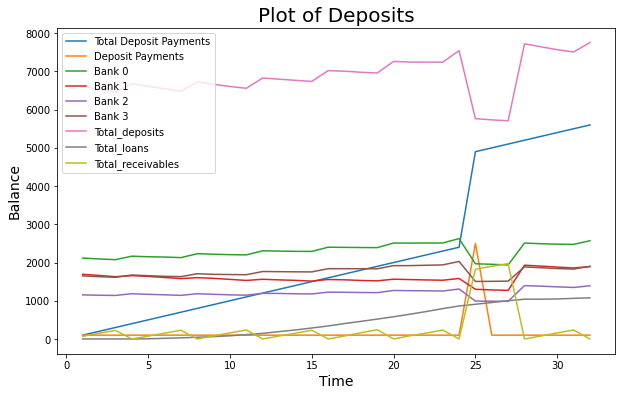

In [289]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))
thesis_data.index = range(len(thesis_data))
thesis_data_plot = thesis_data.drop(["Total Output"], 1).drop([0])
#thesis_data_plot = thesis_data_plot.transform(lambda CBDC_Payments: CBDC_Payments * gdp_calibrate[0]["Num_Firms"]/800 + gdp_calibrate[0]["GDP"])
ax.plot(thesis_data_plot.index, thesis_data_plot)
ax.set_xlabel('Time', fontsize='14')
ax.set_ylabel('Balance', fontsize='14')
ax.legend(['Total Deposit Payments', 'Deposit Payments', "Bank 0 ", "Bank 1", "Bank 2", "Bank 3", "Total_deposits", "Total_loans", "Total_receivables"])
plt.title("Plot of Deposits", size=20)

fig.savefig('figures/Deposit_Payments.png')

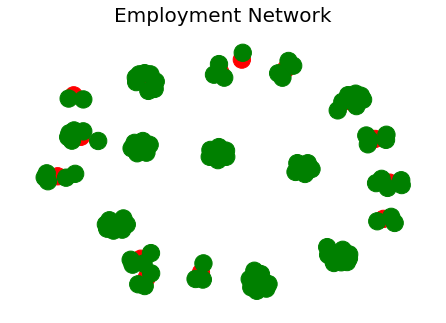

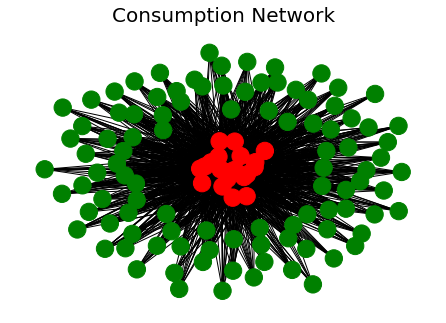

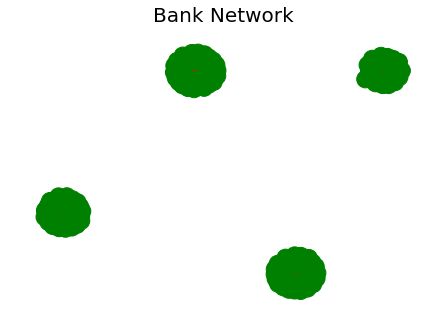

In [290]:
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
# Plot employment network    
E = environment.employment_network
color_map_E = ['red' if "firm" in node else 'green' for node in E]        
nx.draw(E, node_color=color_map_E)
plt.title("Employment Network", size=20)
plt.savefig('figures/employment_network.png')
plt.show()
# Plot consumption network
C = environment.consumption_network
color_map_C = ['red' if "firm" in node else 'green' for node in C]        
nx.draw(C, node_color=color_map_C)
plt.title("Consumption Network", size=20)
plt.savefig('figures/consumption_network.png')
plt.show()
# Plot bank network
B = environment.bank_network
color_map_B = ['red' if "bank" in node else 'green' for node in B]        
nx.draw(B, node_color=color_map_B)
plt.title("Bank Network", size=20)
plt.savefig('figures/bank_network.png')
plt.show()


In [291]:
# hh = environment.households[0]
# hh_bank_acc = environment.bank_network.adj[hh.identifier]
# firm = environment.firms[0]
# firm_bank_acc = environment.bank_network.adj[firm.identifier]
# time = 1
# k = 100
# print(hh.identifier)
# print(firm.identifier)
# consumption_demand = {"type_": "deposit", "from_" : hh.identifier, "to" : firm.identifier, "amount" : k, "bank_from":hh_bank_acc, "bank_to":firm_bank_acc, "time" : time}
# environment.new_transaction(type_="deposits", asset='', from_= consumption_demand["from_"], to = consumption_demand["to"], amount = consumption_demand["amount"], interest=0.05, maturity=0, time_of_default=-1)

In [292]:
# hh = environment.households[0]
# print(hh.accounts[-1])

# done_list = []  # This keeps the IDs of updated transactions
#     # The above is important as the same transactions may be on the books
#     # of different agents, we don't want to double count the interest
# for agent in environment.agents_generator():  # Iterate over all agents

#     for tranx in agent.accounts:  # Iterate over all transactions
#         if tranx.identifier not in done_list:  # If not amended previously
#             # The below adds the interest on the principal amount

#             tranx.amount = tranx.amount + tranx.amount * tranx.interest
#             # The below makes sure that we don't double count
#             done_list.append(tranx.identifier)

# print(hh.accounts[-1])